In [1]:
# !pip install sentence-transformers

## Gerador de embeddings escolhido: CLIP (Contrastive Language-Image Pretraining)

O modelo CLIP (Contrastive Language-Image Pretraining) foi o escolhido para gerar os embeddings dos produtos, pois ele é capaz de combinar tanto a imagem quanto a descrição textual de cada produto em um único espaço latente. É de nosso interesse que o embedding da imagem e o da descrição fiquem próximos, facilitando a comparação entre diferentes representações do mesmo produto.

Fonte interessante: <https://medium.com/crayon-ai/search-engine-for-clothes-using-clip-2f13d14c6b68>

In [1]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image, ImageFile
import requests
import pandas as pd
import torch

# We use the original clip-ViT-B-32 for encoding images
img_model = SentenceTransformer('clip-ViT-B-32')

# Our text embedding model is aligned to the img_model and maps 50+
# languages to the same vector space
text_model = SentenceTransformer('sentence-transformers/clip-ViT-B-32-multilingual-v1')

c:\Users\Cole\AppData\Local\Programs\Python\Python311\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
c:\Users\Cole\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
c:\Users\Cole\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transfo

### Gerando embeddings

- passa por todas as imagens e gera o embedding
- salva o resultado em um df, de colunas nome_arquivo, emb_0, emb_1 ...
- salva o df em um arquivo parquet

In [2]:
# Puxando base para gerar embeddings
df = pd.read_parquet("datasets/base_animale_categorizada.parquet")

In [3]:
df.head()

,file_path,id_produto,grupo_produto,file_name,link,PRODUTOS,CARACTERISTICAS,LOCALIZACAO_ESTAMPA,COR_PREDOMINANTE,DECOTE_OU_GOLA,...,COMPRIMENTO_MANGA,ESTILO,TIPO_MANGA,TIPO_CINTURA,COMPRIMENTO,MODELAGEM,ESTAMPA,FENDA_PERNA,MODELAGEM_SAIA,TIPO_BARRA
0,animale_images_cropped/blazer/blazer_blazer-al...,03-04-0464-0030,blazer,blazer_blazer-alfaiataria-est-onca-jacquard_be...,https://animaleproductsimages.s3.us-east-1.ama...,03-04-0464-0030,{COMPRIMENTO: MEDIO;MODELAGEM: AJUSTADA;COMPRI...,ROUPA_INTEIRA,BEGE,None,...,COMPRIDA,CASUAL,REGULAR,None,MEDIO,AJUSTADA,ANIMALPRINT_ONCA,None,None,None
1,animale_images_cropped/blazer/blazer_blazer-al...,03-04-0478-6048,blazer,blazer_blazer-alongado-marrom-nozes-sem-lapela...,https://animaleproductsimages.s3.us-east-1.ama...,03-04-0478-6048,{COMPRIMENTO: MEDIO;MODELAGEM: AJUSTADA;COMPRI...,N/A,BEGE,None,...,COMPRIDA,SOCIAL,REGULAR,None,MEDIO,AJUSTADA,SEM_ESTAMPA,None,None,None
2,animale_images_cropped/blazer/blazer_blazer-ci...,03-04-0460-0003,blazer,blazer_blazer-cinque-off-white_off-white_03-04...,https://animaleproductsimages.s3.us-east-1.ama...,03-04-0460-0003,{COMPRIMENTO: MEDIO;MODELAGEM: AJUSTADA;COMPRI...,N/A,BRANCO,None,...,COMPRIDA,SOCIAL,REGULAR,None,MEDIO,AJUSTADA,SEM_ESTAMPA,None,None,None
3,animale_images_cropped/blazer/blazer_blazer-ci...,03-04-0461-0005,blazer,blazer_blazer-cinque-preto_preto_03-04-0461-00...,https://animaleproductsimages.s3.us-east-1.ama...,03-04-0461-0005,{COMPRIMENTO: MEDIO; MODELAGEM: AJUSTADA; COMP...,N/A,PRETO,None,...,COMPRIDA,SOCIAL,REGULAR,None,MEDIO,AJUSTADA,SEM_ESTAMPA,None,None,None
4,animale_images_cropped/blazer/blazer_blazer-co...,03-04-0479-0024,blazer,blazer_blazer-com-transpasse-de-crepe-off-whit...,https://animaleproductsimages.s3.us-east-1.ama...,03-04-0479-0024,{COMPRIMENTO: MEDIO; MODELAGEM: AJUSTADA; COMP...,N/A,BRANCO,None,...,COMPRIDA,SOCIAL,REGULAR,None,MEDIO,AJUSTADA,SEM_ESTAMPA,None,None,None


In [65]:
from tqdm import tqdm

def get_img_embeddings(df, path_column, img_model):
  """
  Função que recebe um dataframe, a coluna que contém o caminho das imagens e o modelo de imagem
  Usa o modelo para conseguir os embeddings da imagem e salva no df
  """
  emb_columns = [f"emb_img_{i}" for i in range(512)]
  
  # Now we load and encode the images
  def load_image(url_or_path):
      if url_or_path.startswith("http://") or url_or_path.startswith("https://"):
          return Image.open(requests.get(url_or_path, stream=True).raw)
      else:
          return Image.open(url_or_path)

  file_names = df[path_column].values
  images = [load_image(img) for img in file_names]
  img_embeddings = img_model.encode(images)

  # Colocando os embeddings no df
  emb_dict = {}
  for i, emb in enumerate(img_embeddings):
    emb_id = df.iloc[i]["id_produto"]
    emb_dict[emb_id] = emb

  df_embs = pd.DataFrame(emb_dict).T

  df_embs.columns = emb_columns
  df_embs["id_produto"] = df_embs.index

  return df_embs.reset_index(drop=True)[["id_produto"] + emb_columns]

def get_text_embeddings(df, text_model):
  """
  Função que recebe um dataframe e o modelo de texto
  Usa o modelo para conseguir os embeddings da coluna desc_produto e salva no df
  """

  emb_columns = [f"emb_text_{i}" for i in range(512)]
  
  # Now we encode the text
  text_embeddings = text_model.encode(df["desc_produto"].values)

  # Colocando os embeddings no df
  emb_dict = {}
  for i, emb in enumerate(text_embeddings):
    emb_id = df.iloc[i]["id_produto"]
    emb_dict[emb_id] = emb

  df_embs = pd.DataFrame(emb_dict).T

  df_embs.columns = emb_columns

  df_embs["id_produto"] = df_embs.index

  return df_embs.reset_index(drop=True)[["id_produto"] + emb_columns]


In [66]:
df.loc[df['id_produto'].duplicated()]

,file_path,id_produto,grupo_produto,file_name,link,PRODUTOS,CARACTERISTICAS,LOCALIZACAO_ESTAMPA,COR_PREDOMINANTE,DECOTE_OU_GOLA,...,ESTILO,TIPO_MANGA,TIPO_CINTURA,COMPRIMENTO,MODELAGEM,ESTAMPA,FENDA_PERNA,MODELAGEM_SAIA,TIPO_BARRA,desc_produto


In [67]:
df_img_embs = get_img_embeddings(df, "file_path", img_model)

In [68]:
df_img_embs.shape

(766, 513)

In [69]:
df_img_embs.to_parquet("datasets/img_embeddings.parquet")
df_img_embs.head(1)

,id_produto,emb_img_0,emb_img_1,emb_img_2,emb_img_3,emb_img_4,emb_img_5,emb_img_6,emb_img_7,emb_img_8,...,emb_img_502,emb_img_503,emb_img_504,emb_img_505,emb_img_506,emb_img_507,emb_img_508,emb_img_509,emb_img_510,emb_img_511
0,03-04-0464-0030,0.159315,-0.024293,-0.117268,0.017468,-0.192906,0.137711,-0.402171,-0.144309,0.939456,...,-0.028948,-0.075428,0.560166,-0.266601,-0.213009,0.003456,0.25105,0.798051,-0.282096,0.032521


### Extraindo descrições dos produtos
As imagens foram nomeadas de forma que contém o ID do produto e sua respectiva descrição. Vamos extrair essas descrições para gerar embeddings dos textos também.

In [70]:
pd.set_option('display.max_colwidth', None)

In [71]:
df['file_name'].sample(2)


433    top-blusa_t-shirt-de-tricot-com-gola-alta-canelada-basic-bege_bege-amanteigado_52-13-5008-09037.jpg
529                                short_bermuda-jeans-box-com-barra-a-fio_jeans-medio_25-05-4056-0105.jpg
Name: file_name, dtype: object

In [72]:
# Iterando nos filedf['file_name'] e pegando tudo após o primeiro -
df['desc_produto'] = df['file_name'].apply(lambda x: x.split("_")[1]).replace("-", " ", regex=True)

In [73]:
df.sample(5)

,file_path,id_produto,grupo_produto,file_name,link,PRODUTOS,CARACTERISTICAS,LOCALIZACAO_ESTAMPA,COR_PREDOMINANTE,DECOTE_OU_GOLA,...,ESTILO,TIPO_MANGA,TIPO_CINTURA,COMPRIMENTO,MODELAGEM,ESTAMPA,FENDA_PERNA,MODELAGEM_SAIA,TIPO_BARRA,desc_produto
447,animale_images_cropped/blusa/top-blusa_top-cropped-de-tricot-canelado-de-alca_verde-summer_52-15-1526-04113.jpg,52-15-1526-04113,blusa,top-blusa_top-cropped-de-tricot-canelado-de-alca_verde-summer_52-15-1526-04113.jpg,https://animaleproductsimages.s3.us-east-1.amazonaws.com/top-blusa_top-cropped-de-tricot-canelado-de-alca_verde-summer_52-15-1526-04113.jpg,52-15-1526-04113,{COMPRIMENTO: CROPPED;MODELAGEM: AJUSTADA;COMPRIMENTO_MANGA: ALÇA;TIPO_MANGA: N/A;DECOTE_OU_GOLA: RETO;AMARRACAO: N/A;COR_PREDOMINANTE: VERDE;LOCALIZACAO_ESTAMPA: N/A;ZOOM_ESTAMPA: N/A;ESTAMPA: SEM_ESTAMPA;ESTILO: CASUAL;},N/A,VERDE,RETO,...,CASUAL,N/A,None,CROPPED,AJUSTADA,SEM_ESTAMPA,None,None,None,top cropped de tricot canelado de alca
308,animale_images_cropped/blusa/top-blusa_blusa-drapeada-com-transpasse-frontal-de_off-white_52-13-5327-0024.jpg,52-13-5327-0024,blusa,top-blusa_blusa-drapeada-com-transpasse-frontal-de_off-white_52-13-5327-0024.jpg,https://animaleproductsimages.s3.us-east-1.amazonaws.com/top-blusa_blusa-drapeada-com-transpasse-frontal-de_off-white_52-13-5327-0024.jpg,52-13-5327-0024,{COMPRIMENTO: CURTA;MODELAGEM: AJUSTADA;COMPRIMENTO_MANGA: ALÇA;TIPO_MANGA: N/A;DECOTE_OU_GOLA: V;AMARRACAO: SIM_NA_FRENTE;COR_PREDOMINANTE: BRANCO;LOCALIZACAO_ESTAMPA: N/A;ZOOM_ESTAMPA: N/A;ESTAMPA: SEM_ESTAMPA;ESTILO: FESTIVO;},N/A,BRANCO,V,...,FESTIVO,N/A,None,CURTA,AJUSTADA,SEM_ESTAMPA,None,None,None,blusa drapeada com transpasse frontal de
91,animale_images_cropped/calca/calca_calca-de-georgette-pantalona-verde-com-detalhe-a-fio_verde-folha_25-34-1661-09258.jpg,25-34-1661-09258,calca,calca_calca-de-georgette-pantalona-verde-com-detalhe-a-fio_verde-folha_25-34-1661-09258.jpg,https://animaleproductsimages.s3.us-east-1.amazonaws.com/calca_calca-de-georgette-pantalona-verde-com-detalhe-a-fio_verde-folha_25-34-1661-09258.jpg,25-34-1661-09258,{COMPRIMENTO: MEIO_CANELA;TIPO_CINTURA: ALTA;MODELAGEM: PANTALONA;TIPO_BARRA: RETA;AMARRACAO: N/A;FENDA_PERNA: N/A;COR_PREDOMINANTE: VERDE;LOCALIZACAO_ESTAMPA: N/A;ZOOM_ESTAMPA: N/A;ESTAMPA: SEM_ESTAMPA;ESTILO: CASUAL;},N/A,VERDE,None,...,CASUAL,None,ALTA,MEIO_CANELA,PANTALONA,SEM_ESTAMPA,N/A,None,RETA,calca de georgette pantalona verde com detalhe a fio
681,animale_images_cropped/vestido/vestido_vestido-de-tricot-verde-com-frente-unica_verde-natureza_07-20-6437-09255.jpg,07-20-6437-09255,vestido,vestido_vestido-de-tricot-verde-com-frente-unica_verde-natureza_07-20-6437-09255.jpg,https://animaleproductsimages.s3.us-east-1.amazonaws.com/vestido_vestido-de-tricot-verde-com-frente-unica_verde-natureza_07-20-6437-09255.jpg,07-20-6437-09255,{COMPRIMENTO_SAIA: MEIO_MENGANNA;COMPRIMENTO_MANGA: SEM_MANGA;TIPO_MANGA: N/A;MODELAGEM_SAIA: REGULAR;FENDA_PERNA: SIM;DECOTE_OU_GOLA: HALTER;AMARRACAO: N/A;COR_PREDOMINANTE: VERDE;LOCALIZACAO_ESTAMPA: N/A;ZOOM_ESTAMPA: N/A;ESTAMPA: SEM_ESTAMPA;ESTILO: CASUAL;},N/A,VERDE,HALTER,...,CASUAL,N/A,None,None,None,SEM_ESTAMPA,SIM,REGULAR,None,vestido de tricot verde com frente unica
713,animale_images_cropped/vestido/vestido_vestido-longo-frente-unica-listra_est-listra-bicolor-narciso-e-sandalo-p_07-20-6360-09552.jpg,07-20-6360-09552,vestido,vestido_vestido-longo-frente-unica-listra_est-listra-bicolor-narciso-e-sandalo-p_07-20-6360-09552.jpg,https://animaleproductsimages.s3.us-east-1.amazonaws.com/vestido_vestido-longo-frente-unica-listra_est-listra-bicolor-narciso-e-sandalo-p_07-20-6360-09552.jpg,07-20-6360-09552,{COMPRIMENTO_SAIA: CALCANHAR;COMPRIMENTO_MANGA: SEM_MANGA;TIPO_MANGA: N/A;MODELAGEM_SAIA: EVASÊ;FENDA_PERNA: SIM;DECOTE_OU_GOLA: HALTER;AMARRACAO: N/A;COR_PREDOMINANTE: AMARELO;LOCALIZACAO_ESTAMPA: ROUPA_INTEIRA;ZOOM_ESTAMPA: GRANDE;ESTAMPA: LISTRADO_VERTICAL;ESTILO: FESTIVO;},ROUPA_INTEIRA,AMARELO,HALTER,...,FESTIVO,N/A,None,None,None,LISTRADO_V

In [74]:
# Gerando embeddings de texto
df_text_embs = get_text_embeddings(df, text_model)

In [75]:
df_text_embs.sample(2)

,id_produto,emb_text_0,emb_text_1,emb_text_2,emb_text_3,emb_text_4,emb_text_5,emb_text_6,emb_text_7,emb_text_8,...,emb_text_502,emb_text_503,emb_text_504,emb_text_505,emb_text_506,emb_text_507,emb_text_508,emb_text_509,emb_text_510,emb_text_511
599,07-20-6829-09905,0.07405,0.089053,-0.263893,0.316145,0.037191,0.059670,-0.077397,-0.731085,0.108441,...,0.003172,0.342663,0.480737,-0.182201,0.242132,0.023117,0.127245,0.199469,-0.046368,0.015264
139,25-34-1769-0105,0.23592,0.004170,0.088307,-0.155897,-0.162139,0.054471,-0.191434,-0.674877,-0.055188,...,-0.103882,0.502462,0.331429,-0.417617,-0.485445,0.152514,0.122728,0.315004,0.078108,0.209894


In [76]:
df_text_embs.to_parquet("datasets/text_embeddings.parquet")

## Testando semelhança entre as descrições

In [77]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Extraímos os embeddings de imagem e texto dos respectivos dataframes
img_embeddings = df_img_embs.iloc[:, 1:].values  # Todas as colunas exceto 'id'
text_embeddings = df_text_embs.iloc[:, 1:].values  # Todas as colunas exceto 'id'

# Calculamos a similaridade de cosseno entre todos os pares de vetores de texto e imagem
# cosine_similarity calcula a similaridade entre cada vetor de um conjunto e cada vetor de outro conjunto
cos_sim = cosine_similarity(text_embeddings, img_embeddings)

# Para cada texto, encontramos a imagem mais similar com base na similaridade de cosseno
for i, text in enumerate(df_text_embs['id_produto']):  # Itera sobre os IDs dos textos
    scores = cos_sim[i]  # Similaridades do texto i com todas as imagens
    max_img_idx = np.argmax(scores)  # Índice da imagem com maior similaridade
    
    print("Texto ID:", text, "\nTexto:", df.iloc[i]['desc_produto'])
    print("Maior Similaridade:", scores[max_img_idx])
    print("Imagem ID:", df_img_embs.iloc[max_img_idx]["id_produto"], df.iloc[max_img_idx]['desc_produto'])
    print(" --------------------- \n")


Texto ID: 03-04-0464-0030 
Texto: blazer alfaiataria est onca jacquard
Maior Similaridade: 0.24679223
Imagem ID: 25-34-1608-04347 calca de algodao cinza nimbus detalhe prega
 --------------------- 

Texto ID: 03-04-0478-6048 
Texto: blazer alongado marrom nozes sem lapela
Maior Similaridade: 0.2616407
Imagem ID: 25-05-4046-0005 bermuda de linho preta
 --------------------- 

Texto ID: 03-04-0460-0003 
Texto: blazer cinque off white
Maior Similaridade: 0.28952307
Imagem ID: 03-04-0491-0003 blazer de crepe off white
 --------------------- 

Texto ID: 03-04-0461-0005 
Texto: blazer cinque preto
Maior Similaridade: 0.27307478
Imagem ID: 25-05-4046-0005 bermuda de linho preta
 --------------------- 

Texto ID: 03-04-0479-0024 
Texto: blazer com transpasse de crepe off white
Maior Similaridade: 0.29386935
Imagem ID: 25-34-1608-04347 calca de algodao cinza nimbus detalhe prega
 --------------------- 

Texto ID: 03-04-0462-09256 
Texto: blazer cropped uno amarelo narciso
Maior Similaridade: 0.

In [78]:
# Função para plotar a imagem a partir do caminho
from matplotlib import pyplot as plt
from PIL import Image

def plot_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Imagem ID: 03-04-0478-6048 blazer alongado marrom nozes sem lapela


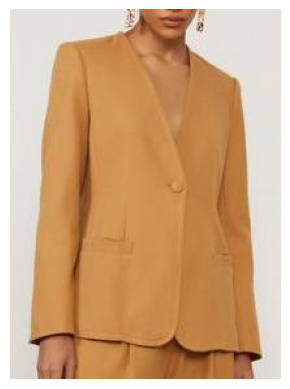

Texto ID: 52-13-5460-09249 
Texto: blusa de malha laranja com decote v e manga longa raglan
Similaridade: 0.30778202
 --------------------- 

Texto ID: 07-20-6538-2019 
Texto: vestido midi de alca decote reto acinturado e saia ampla com cinto laranja
Similaridade: 0.29767329
 --------------------- 

Texto ID: 52-13-5430-09556 
Texto: blusa de georgette leve frente unica amarracao estampado
Similaridade: 0.29292348
 --------------------- 

Texto ID: 07-20-6604-09548 
Texto: vestido midi de georgette pesado manga ampla com recorte estampado
Similaridade: 0.2893265
 --------------------- 

Texto ID: 07-20-6472-09249 
Texto: vestido de georgette curto laranja decote drapeado
Similaridade: 0.28613943
 --------------------- 



In [79]:
# Printando a similaridade de uma imagem com todos os textos
# Escolhendo uma imagem aleatória
img_idx = 1

print("Imagem ID:", df_img_embs.iloc[img_idx]["id_produto"], df.iloc[img_idx]['desc_produto'])

# Calculando a similaridade de cosseno entre a imagem escolhida e todos os textos
scores = cos_sim[:, img_idx]

# Plotando a imagem
image_path = df.iloc[img_idx]['file_path']
plot_image(image_path)

# Ordenando os índices dos textos pelo score em ordem decrescente
sorted_indices = np.argsort(scores)[::-1]

# Printando cada texto com a respectiva similaridade
for i in sorted_indices[:5]:
    text_id = df_text_embs.iloc[i]['id_produto']
    text_desc = df.iloc[i]['desc_produto']
    print("Texto ID:", text_id, "\nTexto:", text_desc)
    print("Similaridade:", scores[i])
    print(" --------------------- \n")


#### Parece que as descrições registradas não estão boas o suficiente.

## Testando com descrições manuais

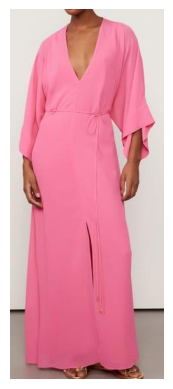

Imagem ID: 07-20-6830-09283 vestido de georgette pesado longo rosa kimono


In [80]:
# Escolhendo uma imagem aleatória
img_idx = 621
image_path = df.iloc[img_idx]['file_path']
plot_image(image_path)

# Printando a descrição cadastrada da imagem
print("Imagem ID:", df_img_embs.iloc[img_idx]["id_produto"], df.iloc[img_idx]['desc_produto'])

In [81]:
# Verificando qual é o texto mais similar a essa imagem
scores = cos_sim[:, img_idx]

max_text_idx = np.argmax(scores)
print("Imagem ID:", df_img_embs.iloc[img_idx]["id_produto"], df.iloc[img_idx]['desc_produto'])
print("Maior Similaridade:", scores[max_text_idx])
print("Texto ID:", df_text_embs.iloc[max_text_idx]["id_produto"], df.iloc[max_text_idx]['desc_produto'])
print(" --------------------- \n")


Imagem ID: 07-20-6830-09283 vestido de georgette pesado longo rosa kimono
Maior Similaridade: 0.29705256
Texto ID: 07-20-6475-09259 vestido de georgete midi rosa frente unica macrame
 --------------------- 



Texto Manual: Vestido longo cor de rosa com mangas compridas e decote em V
Score da descrição manual com a imagem escolhida: 0.2902321
Maior Similaridade: 0.30615255
Imagem ID: 25-34-2006-09283 calca detalhe amarracao na barra rosa
 --------------------- 



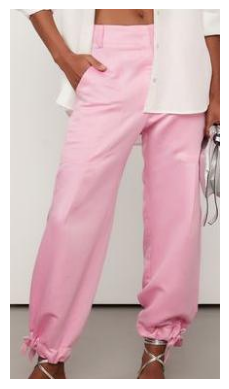

In [82]:
desc_manual= "Vestido longo cor de rosa com mangas compridas e decote em V"
desc_manual_en = "Pink long dress with long sleeves and V-neck"

# embedding do texto
desc_manual_emb = text_model.encode(desc_manual)

# Calculando a similaridade de cosseno entre o texto manual e todas as imagens
cos_sim_manual = cosine_similarity([desc_manual_emb], img_embeddings)

scores = cos_sim_manual[0]  # Similaridades do texto manual com todas as imagens

# Mostrando a imagem com maior similaridade com o texto manual
max_img_idx = np.argmax(scores)
print("Texto Manual:", desc_manual)

# Mostrando a similaridade com a imagem com o id img_idx
score_img_idx = scores[img_idx]

print("Score da descrição manual com a imagem escolhida:", score_img_idx)

print("Maior Similaridade:", scores[max_img_idx])
print("Imagem ID:", df_img_embs.iloc[max_img_idx]["id_produto"], df.iloc[max_img_idx]['desc_produto'])
print(" --------------------- \n")

plot_image(df.iloc[max_img_idx]['file_path'])

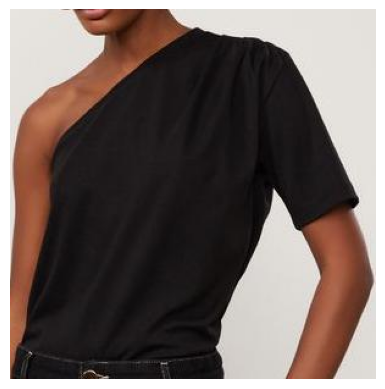

In [83]:
# Escolhendo uma imagem aleatória
img_idx = 333

image_path = df.iloc[img_idx]['file_path']
plot_image(image_path)

In [84]:
# Verificando qual é o texto mais similar a essa imagem
scores = cos_sim[:, img_idx]

max_text_idx = np.argmax(scores)
print("Imagem ID:", df_img_embs.iloc[img_idx]["id_produto"], df.iloc[img_idx]['desc_produto'])
print("Maior Similaridade:", scores[max_text_idx])
print("Texto ID:", df_text_embs.iloc[max_text_idx]["id_produto"], df.iloc[max_text_idx]['desc_produto'])
print(" --------------------- \n")


Imagem ID: 52-13-5559-0005 camiseta assimetrica
Maior Similaridade: 0.328326
Texto ID: 52-13-5009-0005 blusa de tricot com manga longa e decote redondo color preto
 --------------------- 



Texto Manual: Camiseta preta com uma manga só
Maior Similaridade: 0.29433915
Imagem ID: 52-13-5559-0005 camiseta assimetrica
 --------------------- 



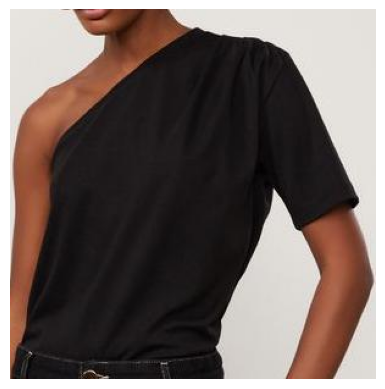

In [174]:
desc_manual = "Camiseta preta com uma manga só"

# embedding do texto
desc_manual_emb = text_model.encode(desc_manual)

# Calculando a similaridade de cosseno entre o texto manual e todas as imagens
cos_sim_manual = cosine_similarity([desc_manual_emb], img_embeddings)

scores = cos_sim_manual[0]  # Similaridades do texto manual com todas as imagens

# Mostrando a imagem com maior similaridade com o texto manual
max_img_idx = np.argmax(scores)
print("Texto Manual:", desc_manual)
print("Maior Similaridade:", scores[max_img_idx])
print("Imagem ID:", df_img_embs.iloc[max_img_idx]["id_produto"], df.iloc[max_img_idx]['desc_produto'])
print(" --------------------- \n")

plot_image(df.iloc[max_img_idx]['file_path'])

---


In [86]:
# Cruzando df e df_img_embs pra pegar grupo_produto
df_img_embs = pd.merge(df_img_embs, df[['id_produto', 'grupo_produto']], on="id_produto", how="left")

In [87]:
df_img_embs

,id_produto,emb_img_0,emb_img_1,emb_img_2,emb_img_3,emb_img_4,emb_img_5,emb_img_6,emb_img_7,emb_img_8,...,emb_img_503,emb_img_504,emb_img_505,emb_img_506,emb_img_507,emb_img_508,emb_img_509,emb_img_510,emb_img_511,grupo_produto
0,03-04-0464-0030,0.159315,-0.024293,-0.117268,0.017468,-0.192906,0.137711,-0.402171,-0.144309,0.939456,...,-0.075428,0.560166,-0.266601,-0.213009,0.003456,0.251050,0.798051,-0.282096,0.032521,blazer
1,03-04-0478-6048,-0.054035,0.210889,0.121748,0.122241,-0.188613,0.181957,-0.546432,-0.593038,0.491988,...,-0.138086,0.505052,-0.106603,-0.323217,0.086038,0.390587,0.986789,-0.125528,0.456620,blazer
2,03-04-0460-0003,-0.055339,0.376676,0.194497,0.267525,-0.240985,0.248852,-0.274237,-0.295000,0.566380,...,0.288448,0.961003,-0.158184,-0.075985,-0.393318,0.039428,0.660712,-0.019683,-0.080595,blazer
3,03-04-0461-0005,-0.039712,0.253769,0.223714,0.024840,-0.001702,0.225233,-0.487728,0.329303,0.675198,...,-0.092576,0.788266,-0.300475,-0.480824,0.114495,0.257658,0.308829,-0.102123,0.451775,blazer
4,03-04-0479-0024,-0.108800,0.091291,0.057245,0.337540,0.081135,-0.222907,-0.204011,0.349029,0.904539,...,0.094541,0.865604,0.263496,-0.160512,-0.463765,0.182257,0.214232,-0.032568,-0.254120,blazer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,07-20-6778-0005,0.019623,0.102202,-0.036990,0.455425,-0.337472,0.351344,-0.092960,0.389567,0.625612,...,-0.099625,0.346413,-0.277054,0.040731,-0.580248,-0.106754,0.754394,-0.125312,0.119866,vestido
762,07-20-6402-09248,0.100392,-0.032767,-0.091637,0.404944,-0.598882,0.194458,-0.408226,-0.579717,0.427830,...,-0.199756,0.095518,0.122175,-0.062147,-0.073805,0.037836,0.989817,-0.157222,0.231829,vestido
763,07-20-6401-0005,0.166221,-0.189078,-0.312695,0.481503,-0.309427,0.435620,-0.162573,0.445066,0.260107,...,-0.288520,0.117256,0.030498,-0.306072,-0.199355,0.063874,0.299538,-0.106902,-0.006913,vestido
764,07-20-6659-09538,0.167080,-0.391681,-0.015006,0.289606,-0.200403,0.050729,-0.315043,-1.028018,0.580867,...,-0.363056,0.518750,0.049510,-0.099344,-0.377340,0.139283,1.364434,-0.356402,0.571959,vestido


In [124]:
df_img_embs_blusa = df_img_embs[df_img_embs["grupo_produto"].str.contains("blusa")]

In [125]:
# Reset index 
df_img_embs_blusa.reset_index(drop=True, inplace=True)

In [126]:
img_embeddings_blusa = df_img_embs_blusa.drop(columns={'grupo_produto', 'id_produto'}).values

In [127]:
img_embeddings_blusa.shape

(299, 512)

Texto Manual: top cropped
Maior Similaridade: 0.23473297
Imagem ID: 52-08-0790-0003 top faixa de renda flores intimates
 --------------------- 



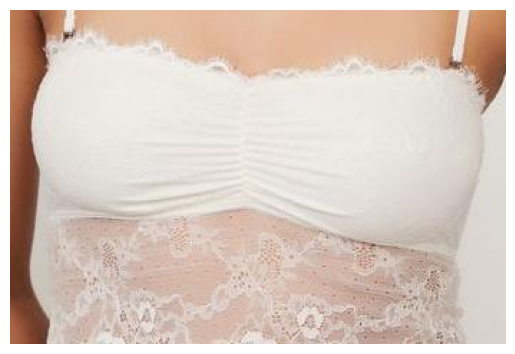

In [192]:
desc_manual = "top cropped"

# embedding do texto
desc_manual_emb = text_model.encode(desc_manual)

# Calculando a similaridade de cosseno entre o texto manual e todas as imagens de vestidos
cos_sim_manual = cosine_similarity([desc_manual_emb], img_embeddings_blusa)

scores = cos_sim_manual[0]  # Similaridades do texto manual com todas as imagens

# Mostrando a imagem com maior similaridade com o texto manual
max_img_idx = np.argmax(scores)
print("Texto Manual:", desc_manual)
print("Maior Similaridade:", scores[max_img_idx])

id_image = df_img_embs_blusa.iloc[max_img_idx]['id_produto']
image_path = df[df['id_produto'] == id_image]['file_path'].values[0]
desc_image = df[df['id_produto'] == id_image]['desc_produto'].values[0]

print("Imagem ID:", id_image, desc_image)
print(" --------------------- \n")
plot_image(image_path)

### Conclusões:
O modelo consegue identificar características relevantes das imagens e textos, permitindo encontrar
imagens similares a partir de descrições textuais, mas de forma muito generalizada. Para melhorar a 
precisão do modelo, seria necessário um fine-tuning com um dataset específico para o domínio de interesse.

Uma segunda avaliação tentando identificar nas roupas atibutos de modelagem (como comprimento, decote, manga) ficou claro a incapacidade do modelo de compreender essas características. Devido a isso, para conseguir extrair de forma efetiva essas informações das descrições textuais, o fine-tuning torna-se indispensável.

In [111]:
df

,file_path,id_produto,grupo_produto,file_name,link,PRODUTOS,CARACTERISTICAS,LOCALIZACAO_ESTAMPA,COR_PREDOMINANTE,DECOTE_OU_GOLA,...,ESTILO,TIPO_MANGA,TIPO_CINTURA,COMPRIMENTO,MODELAGEM,ESTAMPA,FENDA_PERNA,MODELAGEM_SAIA,TIPO_BARRA,desc_produto
0,animale_images_cropped/blazer/blazer_blazer-alfaiataria-est-onca-jacquard_bege_03-04-0464-0030.jpg,03-04-0464-0030,blazer,blazer_blazer-alfaiataria-est-onca-jacquard_bege_03-04-0464-0030.jpg,https://animaleproductsimages.s3.us-east-1.amazonaws.com/blazer_blazer-alfaiataria-est-onca-jacquard_bege_03-04-0464-0030.jpg,03-04-0464-0030,{COMPRIMENTO: MEDIO;MODELAGEM: AJUSTADA;COMPRIMENTO_MANGA: COMPRIDA;TIPO_MANGA: REGULAR;COR_PREDOMINANTE: BEGE;LOCALIZACAO_ESTAMPA: ROUPA_INTEIRA;ZOOM_ESTAMPA: MEDIO;ESTAMPA: ANIMALPRINT_ONCA;ESTILO: CASUAL;},ROUPA_INTEIRA,BEGE,None,...,CASUAL,REGULAR,None,MEDIO,AJUSTADA,ANIMALPRINT_ONCA,None,None,None,blazer alfaiataria est onca jacquard
1,animale_images_cropped/blazer/blazer_blazer-alongado-marrom-nozes-sem-lapela_marrom-nozes_03-04-0478-6048.jpg,03-04-0478-6048,blazer,blazer_blazer-alongado-marrom-nozes-sem-lapela_marrom-nozes_03-04-0478-6048.jpg,https://animaleproductsimages.s3.us-east-1.amazonaws.com/blazer_blazer-alongado-marrom-nozes-sem-lapela_marrom-nozes_03-04-0478-6048.jpg,03-04-0478-6048,{COMPRIMENTO: MEDIO;MODELAGEM: AJUSTADA;COMPRIMENTO_MANGA: COMPRIDA;TIPO_MANGA: REGULAR;COR_PREDOMINANTE: BEGE;LOCALIZACAO_ESTAMPA: N/A;ZOOM_ESTAMPA: N/A;ESTAMPA: SEM_ESTAMPA;ESTILO: SOCIAL;},N/A,BEGE,None,...,SOCIAL,REGULAR,None,MEDIO,AJUSTADA,SEM_ESTAMPA,None,None,None,blazer alongado marrom nozes sem lapela
2,animale_images_cropped/blazer/blazer_blazer-cinque-off-white_off-white_03-04-0460-0003.jpg,03-04-0460-0003,blazer,blazer_blazer-cinque-off-white_off-white_03-04-0460-0003.jpg,https://animaleproductsimages.s3.us-east-1.amazonaws.com/blazer_blazer-cinque-off-white_off-white_03-04-0460-0003.jpg,03-04-0460-0003,{COMPRIMENTO: MEDIO;MODELAGEM: AJUSTADA;COMPRIMENTO_MANGA: COMPRIDA;TIPO_MANGA: REGULAR;COR_PREDOMINANTE: BRANCO;LOCALIZACAO_ESTAMPA: N/A;ZOOM_ESTAMPA: N/A;ESTAMPA: SEM_ESTAMPA;ESTILO: SOCIAL;},N/A,BRANCO,None,...,SOCIAL,REGULAR,None,MEDIO,AJUSTADA,SEM_ESTAMPA,None,None,None,blazer cinque off white
3,animale_images_cropped/blazer/blazer_blazer-cinque-preto_preto_03-04-0461-0005.jpg,03-04-0461-0005,blazer,blazer_blazer-cinque-preto_preto_03-04-0461-0005.jpg,https://animaleproductsimages.s3.us-east-1.amazonaws.com/blazer_blazer-cinque-preto_preto_03-04-0461-0005.jpg,03-04-0461-0005,{COMPRIMENTO: MEDIO; MODELAGEM: AJUSTADA; COMPRIMENTO_MANGA: COMPRIDA; TIPO_MANGA: REGULAR; COR_PREDOMINANTE: PRETO; LOCALIZACAO_ESTAMPA: N/A; ZOOM_ESTAMPA: N/A; ESTAMPA: SEM_ESTAMPA; ESTILO: SOCIAL;},N/A,PRETO,None,...,SOCIAL,REGULAR,None,MEDIO,AJUSTADA,SEM_ESTAMPA,None,None,None,blazer cinque preto
4,animale_images_cropped/blazer/blazer_blazer-com-transpasse-de-crepe-off-white_off-white_03-04-0479-0024.jpg,03-04-0479-0024,blazer,blazer_blazer-com-transpasse-de-crepe-off-white_off-white_03-04-0479-0024.jpg,https://animaleproductsimages.s3.us-east-1.amazonaws.com/blazer_blazer-com-transpasse-de-crepe-off-white_off-white_03-04-0479-0024.jpg,03-04-0479-0024,{COMPRIMENTO: MEDIO; MODELAGEM: AJUSTADA; COMPRIMENTO_MANGA: COMPRIDA; TIPO_MANGA: REGULAR; COR_PREDOMINANTE: BRANCO; LOCALIZACAO_ESTAMPA: N/A; ZOOM_ESTAMPA: N/A; ESTAMPA: SEM_ESTAMPA; ESTILO: SOCIAL;},N/A,BRANCO,None,...,SOCIAL,REGULAR,None,MEDIO,AJUSTADA,SEM_ESTAMPA,None,None,None,blazer com transpasse de crepe off white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,animale_images_cropped/vestido/vestido_vestido-tricot-transparencia_preto_07-20-6778-0005.jpg,07-20-6778-0005,vestido,vestido_vestido-tricot-transparencia_preto_07-20-6778-0005.jpg,https://animaleproductsimages.s3.us-east-1.amazonaws.com/vestido_vestido-tricot-transparencia_preto_07-20-6778-0005.jpg,07-20-6778-0005,{COMPRIMENTO_SAIA: CALCANHAR;COMPRIMENTO_MANGA: SEM_MANGA;TIPO_MANGA: N/A;MODELAGEM_SAIA: REGULAR;FENDA_

In [112]:
# Salvando df em parquet
df.to_parquet("datasets/base.parquet")